In [1]:
# Code source: Sebastian Curi and Andreas Krause, based on Jaques Grobler (sklearn demos).
# License: BSD 3 clause

# We start importing some modules and running some magic commands
%matplotlib inline
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

# General math and plotting modules.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import erfinv
from scipy import linalg
from scipy.stats import multivariate_normal, norm

# Project files.
from utilities.util import gradient_descent
from utilities.classifiers import Logistic
from utilities.regularizers import L2Regularizer
from utilities.load_data import polynomial_data, linear_separable_data
from utilities import plot_helpers
from utilities.widgets import noise_widget, n_components_widget, min_prob_widget

# Widget and formatting modules
import IPython
import ipywidgets
from ipywidgets import interact, interactive, interact_manual, fixed
from matplotlib import rcParams
import matplotlib as mpl 

# If in your browser the figures are not nicely vizualized, change the following line. 
rcParams['figure.figsize'] = (10, 5)
rcParams['font.size'] = 16

# Machine Learning library. 
import torch 
import torch.jit
import torch.nn as nn 
import torchvision
from torchvision import transforms, datasets


import warnings
warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GMM Generative Model

In [2]:
class GMM(object):
    """Base class for isotropic GMMs. 
    
    Parameters
    ----------
    weights: np.ndarray 
        Array with weights of each blob, will get normalized internally. Size k. 
    
    means: np.ndarray 
        Array with location of each center. Size k x d. 
    
    scales: np.ndarray
        Array with scale of each center. Size k x d. Only isotropic
    
    """
    def __init__(self, weights, means, scales):
        self.num_centers = len(weights)
        self.weights = weights / np.sum(weights)
        self.means = means
        self.scales = scales 
    
    def sample(self, batch_size=1):
        """Sample `batch_size` points from the GMM model."""
        centers = np.random.choice(self.num_centers, batch_size, p=self.weights)
        eps = np.random.randn(batch_size)
        return self.means[centers] + eps * self.scales[centers]

In [3]:
def plot_gmm(true_model, sampling_model, discriminator=None, title=None):
    """Plot GMM utility."""
    gaussians = [norm(mean, scale) for mean, scale in zip(true_model.means, true_model.scales)]
    scale = sum(true_model.weights)
    fig, ax = plt.subplots(1, 1)
    X = np.linspace(-1.25, 1.25, 1000)
    y = np.zeros_like(X)
    for i, (weight, gaussian) in enumerate(zip(true_model.weights, gaussians)):
        y += weight * gaussian.pdf(X) / scale

    ax.plot(X, y, label='Exact PDF')
    try:
        ax.hist(sampling_model.sample(10000), bins=100, density=True, label='Samples')
    except ValueError:
        ax.hist(sampling_model.sample(10000)[0][:, 0], bins=100, density=True, label='Samples')
    
    ax.plot([], [], color="g", label="Prob[Real]")
    if discriminator is not None:
        ax2 = ax.twinx()  
        ax2.plot(X, discriminator(torch.tensor(X).unsqueeze(-1).float()).detach().numpy(), color="g")
        ax2.set_ylim([0, 1])
#         ax2.set_ylim([0.4, 0.6])
        ax2.set_ylabel("Probability")

    ax.legend(loc='best')
    
    
    # This is hard coded for the GMMs in the next cells. 
    if true_model.num_centers == 1:
        ax.set_ylim([0, 3.0])
        ax.set_xlim([-0.25, 1.25])
    else:
        ax.set_ylim([0, 5.0])
        ax.set_xlim([-1.25, 1.25])
        
    ax.set_title(title)
    IPython.display.clear_output(wait=True)
    IPython.display.display(fig)
    plt.close()


# GAN Architecture

In [4]:
class Generator(nn.Module):
    """Given a random input, produce a random output."""

    def __init__(self, input_dim: int, output_dim: int, noise='uniform'):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        
        self.noise = noise
        
        self.main = nn.Sequential(
            nn.Linear(input_dim, 15),
            nn.ReLU(True),
            nn.Linear(15, output_dim),
            nn.Tanh()  # Distribution is bounded between -1 and 1.
        )

    def forward(self, x):
        return self.main(x)

    def rsample(self, batch_size=1):
        """Get a differentiable sample of the generator model."""
        if self.noise == 'uniform':
            noise = torch.rand(batch_size, self.input_dim)

        elif self.noise == 'normal':
            noise = torch.randn(batch_size, self.input_dim)
        else:
            raise NotImplementedError
            
        return self(noise).squeeze(-1)

    def sample(self, batch_size=1):
        """Get a sample of the generator model."""
        return self.rsample(batch_size).detach()


class Discriminator(nn.Module):
    """Discriminate if true from fake samples."""

    def __init__(self, input_dim: int):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 25),
            nn.ReLU(True),
            nn.Linear(25, 1),
            nn.Sigmoid()  # Output is bounded between 0 and 1.
        )

    def forward(self, x):
        return self.main(x).squeeze(-1)


# GAN Training Algorithm

In [5]:
def train_gan(generator, discriminator, true_model, generator_optimizer, discriminator_optimizer, 
              num_iter, discriminator_loss, generator_loss, plot_freq=1000, batch_size=64):
    loss = nn.BCELoss()
    for i in range(num_iter):
        true_data = torch.tensor(true_model.sample(batch_size)).float().unsqueeze(-1)
        fake_data = generator.rsample(batch_size).unsqueeze(-1)
        # equivalently, fake_data = generator(torch.randn(batch_size, code_size)).squeeze()

        true_label = torch.full((batch_size,), 1.)
        fake_label = torch.full((batch_size,), 0.)

        ###################################################################################
        # Update G network: maximize log(D(G(z)))                                         #
        ###################################################################################
        generator_optimizer.zero_grad()
        loss_g = loss(discriminator(fake_data), true_label)  # true label.
        loss_g.backward()
        generator_optimizer.step()

        generator_loss.append(loss_g.item())

        ###################################################################################
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))                         #
        ###################################################################################
        discriminator_optimizer.zero_grad()

        # train on true data.
        loss_d_true = loss(discriminator(true_data), true_label)
        loss_d_true.backward()

        # train on fake data.
        loss_d_fake = loss(discriminator(fake_data.detach()), fake_label)
        loss_d_fake.backward()

        discriminator_optimizer.step()

        loss_d = loss_d_true + loss_d_fake
        discriminator_loss.append(loss_d.item())

        if plot_freq and i % plot_freq == 0:
            ax = plot_gmm(true_model, generator, discriminator, f"Episode {i}")
    
    return discriminator_loss, generator_loss


def train_gan_interactive(num_iter, true_model, noise_model, noise_dim, generator_lr, discriminator_lr, seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    generator = Generator(input_dim=noise_dim, output_dim=1, noise=noise_model)
    discriminator = Discriminator(input_dim=1)
    
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=generator_lr, betas=(0.5, 0.999))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=(0.5, 0.99))

    discriminator_loss, generator_loss = [], []
    try:
        train_gan(generator, discriminator, true_model, generator_optimizer, discriminator_optimizer, num_iter, discriminator_loss, generator_loss)
    except KeyboardInterrupt:
        pass

    plot_gmm(true_model, generator, discriminator, "Final Generator Model")
    plt.plot(generator_loss, label='Generator Loss')
    plt.plot(discriminator_loss, label='Discriminator Loss')
    plt.xlabel('Iteration Number')
    plt.ylabel(' Loss')
    plt.legend(loc='best')
    plt.show()
    

# GAN's for fitting a Gaussian

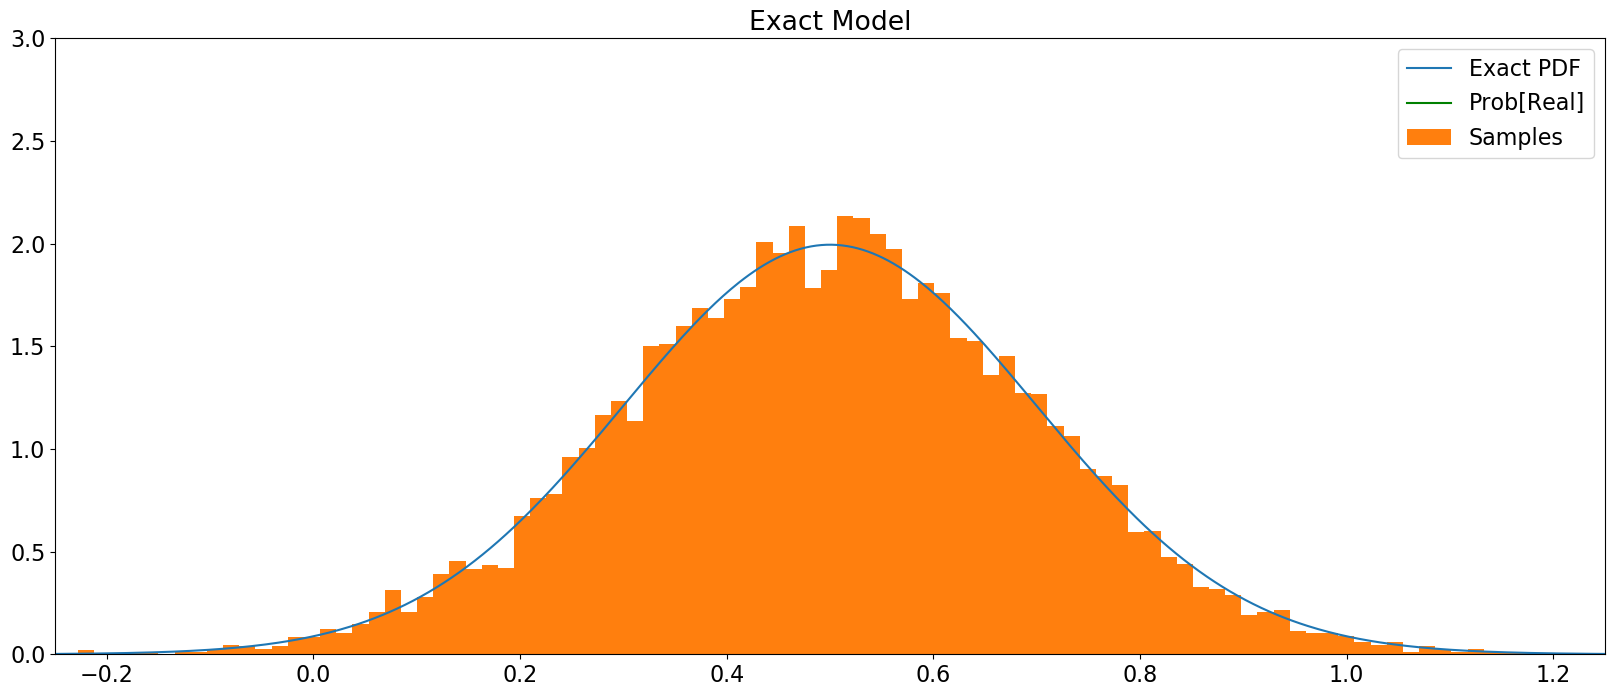

In [6]:
rcParams['figure.figsize'] = (20, 8)
rcParams['font.size'] = 16

gaussian_model = GMM(weights=np.array([1.]),means=np.array([0.5]), scales=np.array([0.2])) 
plot_gmm(gaussian_model, gaussian_model, title='Exact Model')

In [7]:
rcParams['figure.figsize'] = (20, 8)
rcParams['font.size'] = 16
num_iter = 15000

noise_model_widget = ipywidgets.Dropdown(options=['uniform', 'normal'], value='normal', description='Generator noise model:', style={'description_width': 'initial'}, continuous_update=False)
noise_dim_widget = ipywidgets.IntSlider(min=4, max=10, value=2, description='Noise dimension:', style={'description_width': 'initial'}, continuous_update=False)
generator_lr_widget = ipywidgets.FloatLogSlider(value=1e-4, min=-6, max=0, description="Generator lr", style={'description_width': 'initial'}, continuous_update=False)
discriminator_lr_widget = ipywidgets.FloatLogSlider(value=1e-3, min=-6, max=0, description="Discriminator lr", style={'description_width': 'initial'}, continuous_update=False)
                
interact_manual(
    lambda noise_model, noise_dim, generator_lr, discriminator_lr: train_gan_interactive(
    num_iter, gaussian_model, noise_model, noise_dim, generator_lr, discriminator_lr, seed=2),
                noise_model=noise_model_widget,
                noise_dim=noise_dim_widget,
                generator_lr=generator_lr_widget,
                discriminator_lr=discriminator_lr_widget
               );

# In orange the histogram of the samples produced by the generator is shown. 
# In blue the exact pdf of the model 
# In green the discriminator probability of a sample being real. 

interactive(children=(Dropdown(description='Generator noise model:', index=1, options=('uniform', 'normal'), s…

# GAN's for fitting a GMM

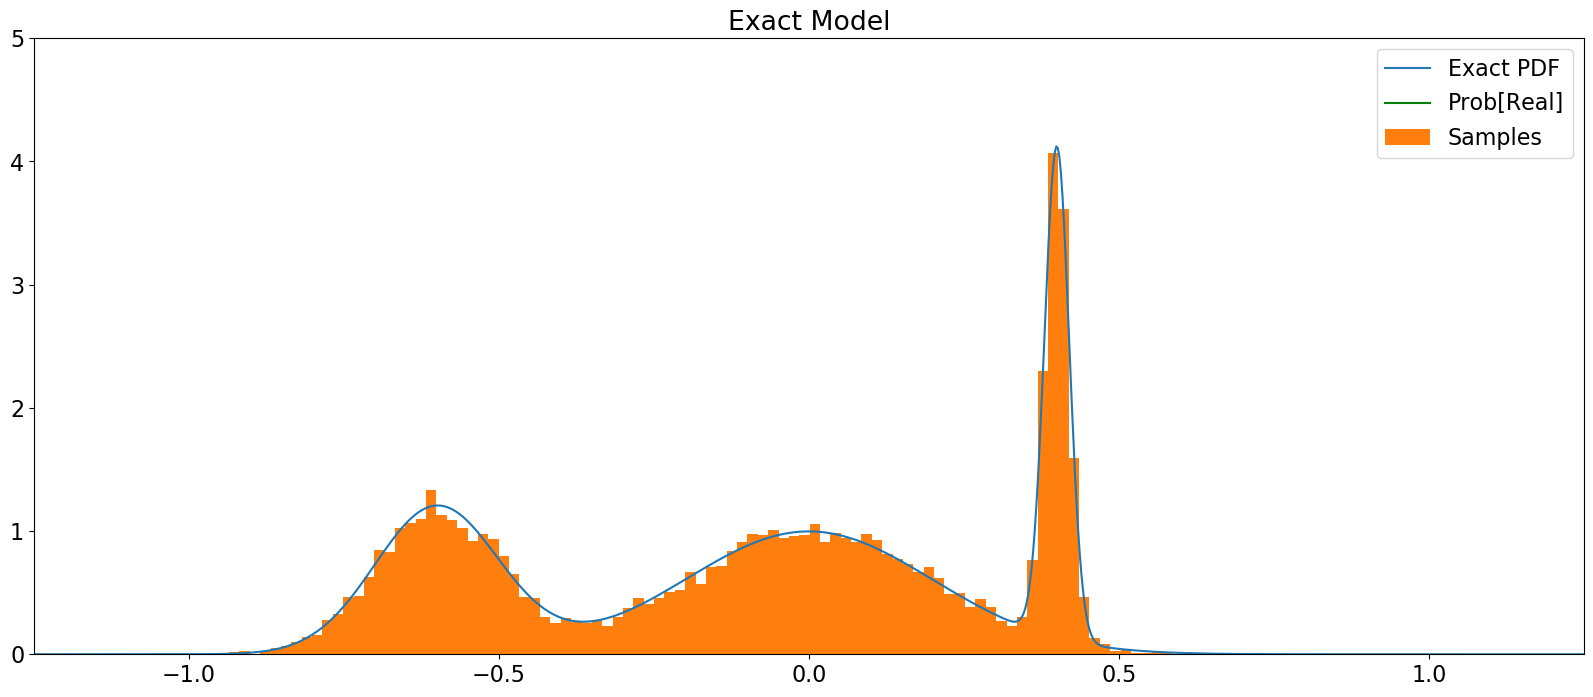

In [8]:
rcParams['figure.figsize'] = (20, 8)
rcParams['font.size'] = 16

gmm_model = GMM(weights=np.array([0.3, 0.5, 0.2]),
                 means=np.array([-3., 0., 2.]) / 5,
                 scales=np.array([0.5, 1.0, 0.1]) / 5)
plot_gmm(gmm_model, gmm_model, title='Exact Model')

In [9]:
rcParams['figure.figsize'] = (20, 8)
rcParams['font.size'] = 16
num_iter = 15000

noise_model_widget = ipywidgets.Dropdown(options=['uniform', 'normal'], value='normal', description='Generator noise model:', style={'description_width': 'initial'}, continuous_update=False)
noise_dim_widget = ipywidgets.IntSlider(min=1, max=10, value=8, description='Noise dimension:', style={'description_width': 'initial'}, continuous_update=False)
generator_lr_widget = ipywidgets.FloatLogSlider(value=1e-4, min=-6, max=0, description="Generator lr", style={'description_width': 'initial'}, continuous_update=False)
discriminator_lr_widget = ipywidgets.FloatLogSlider(value=1e-3, min=-6, max=0, description="Discriminator lr", style={'description_width': 'initial'}, continuous_update=False)


interact_manual(lambda noise_model, noise_dim, generator_lr, discriminator_lr: train_gan_interactive(
    num_iter, gmm_model, noise_model, noise_dim, generator_lr, discriminator_lr),
                noise_model=noise_model_widget,
                noise_dim=noise_dim_widget,
                generator_lr=generator_lr_widget,
                discriminator_lr=discriminator_lr_widget
               );
# Generator lr <= 1e-5 shows mode collapse
# Generator lr >= 1e-3 shows oscillation


interactive(children=(Dropdown(description='Generator noise model:', index=1, options=('uniform', 'normal'), s…

# DCGANs

In [10]:
import torchvision 
from torchvision import transforms

MNIST = True 
torchvision.datasets.MNIST.resources = [
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
        ]

if MNIST:
    from mnist_dcgan.dcgan import Discriminator, Generator
    tranforms_ = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5, ))])
    dataset = torchvision.datasets.MNIST('../data', train=True, download=True, transform=tranforms_)
    d_path = 'mnist_dcgan/weights/netD_epoch_99.pth'
    g_path = 'mnist_dcgan/weights/netG_epoch_99.pth'

else:
    from cifar10_dcgan.dcgan import Discriminator, Generator

    transforms_ = transforms.Compose([
                                   transforms.Resize(64),
                                   transforms.ToTensor(),
#                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ])
    dataset = torchvision.datasets.CIFAR10('../data', train=True, download=True, transform=tranforms_)
    d_path = 'cifar10_dcgan/weights/netD_epoch_199.pth'
    g_path = 'cifar10_dcgan/weights/netG_epoch_199.pth'
    
N = len(dataset)

D = Discriminator(ngpu=0).eval()
G = Generator(ngpu=0).eval()


# load weights

# load weights
D.load_state_dict(torch.load(d_path, map_location=torch.device('cpu')))
G.load_state_dict(torch.load(g_path, map_location=torch.device('cpu')))

batch_size = 1
latent_size = 100

def sample_image():
    true_button = ipywidgets.Button(description="True Image")
    fake_button = ipywidgets.Button(description="Fake Image")
    reset_button = ipywidgets.Button(description="Resample Image")
    hint_button = ipywidgets.Button(description="Show Hint")
    
    def print_string(correct, choice, alternative):
        if correct:
            print(f"Correct! The image was {choice}")
        else:
            print(f"Incorrect: The image was {alternative}")
            
    def is_true(b):
        global true_image
        print_string(true_image == 1, "Real", "Fake")
        display(reset_button)
        
    def is_fake(b):
        global true_image
        print_string(true_image == 0, "Fake", "Real")
        display(reset_button)
        
    def hint(b):
        global probs 
        print(f"The discriminator thinks it is real with {probs.item():.2f} probability")
        
    def reset(b):
        IPython.display.clear_output(wait=True)
        plt.close()
        plt.figure(figsize = (3,3)) 
        
        global true_image, probs
        
        noise = torch.randn(batch_size, latent_size, 1, 1)
        true_image = np.random.choice(2)

        if true_image:
            image = dataset[np.random.choice(N)][0].unsqueeze(0)
        else:
            image = G(noise)
        probs = D(image)

        image_np = image.cpu().detach().numpy()
        if MNIST:
            plt.imshow(image_np[0, 0], cmap="gray")
        else:   
            plt.imshow(image_np[0].transpose(1, 2, 0), interpolation="bilinear")
    
        display(true_button)
        display(fake_button)
        display(hint_button)


    true_button.on_click(is_true)
    fake_button.on_click(is_fake)
    hint_button.on_click(hint)
    reset_button.on_click(reset)
    
    reset(None)
    
interact(sample_image);

interactive(children=(Output(),), _dom_classes=('widget-interact',))

Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/zipball/hub" to /Users/bunnech/.cache/torch/hub/hub.zip
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/PGAN/celebaHQ16_december_s7_i96000-9c72988c.pth" to /Users/bunnech/.cache/torch/hub/checkpoints/celebaHQ16_december_s7_i96000-9c72988c.pth



Average network found !


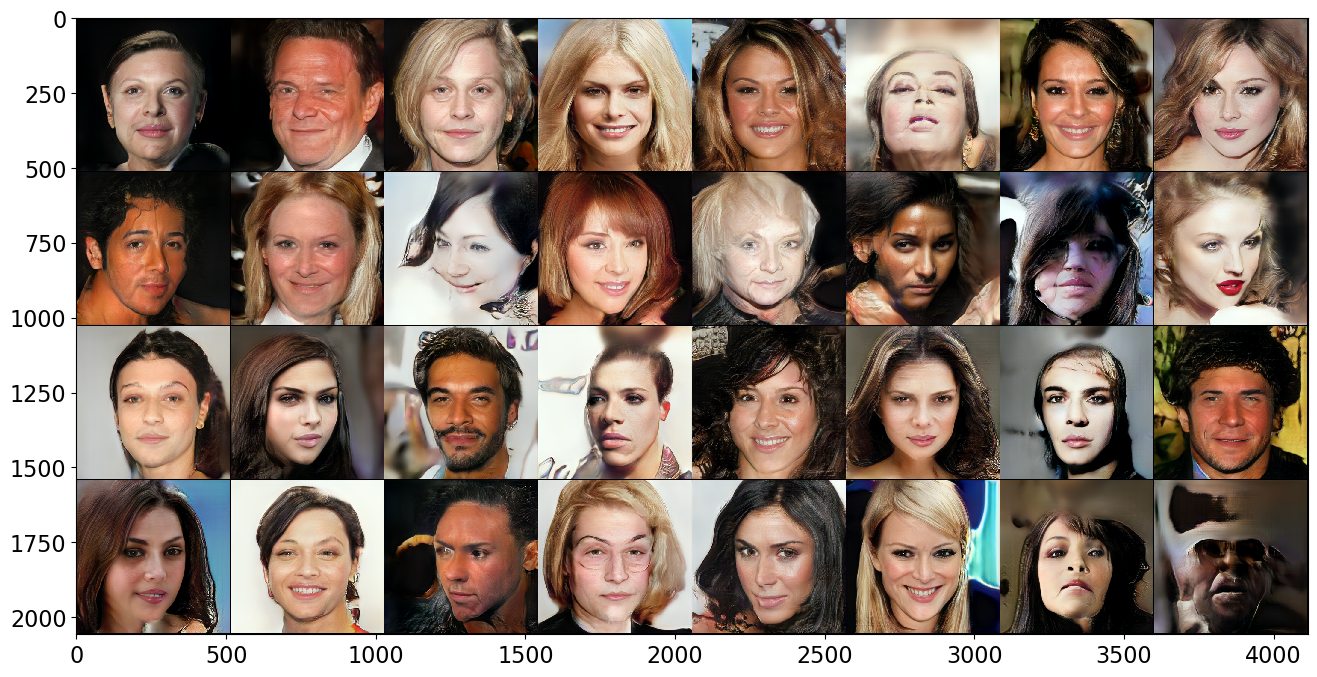

In [11]:
import matplotlib.pyplot as plt
import torchvision

num_images = 32
use_gpu = False
gan = 'PGAN'
model_name = 'celebAHQ-512'
# model_name = 'celeba'


model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', gan, model_name=model_name, pretrained=True, useGPU=use_gpu)

noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

# let's plot these images using torchvision and matplotlib

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())